C:\Users\reald\AppData\Local\Temp\ipykernel_31520\3654757051.py:110: UserWarning: Glyph 128248 (\N{CAMERA WITH FLASH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\reald\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128248 (\N{CAMERA WITH FLASH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


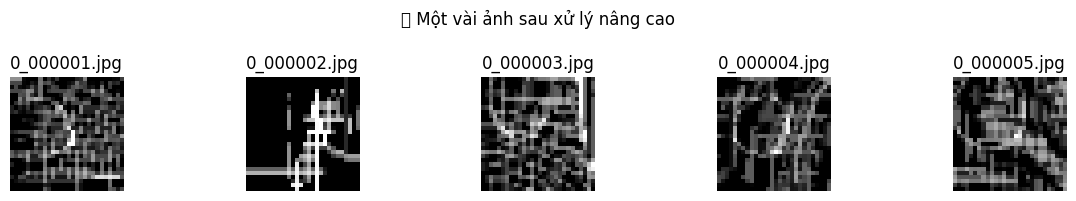

📂 Đọc dữ liệu có nhãn: 100%|██████████| 7601/7601 [01:14<00:00, 102.24it/s]


✅ Tổng số ảnh có nhãn: 7601
🧠 Đang huấn luyện mô hình Random Forest...
🎯 Accuracy trên tập test: 59.57%

📊 Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.67      0.62      0.64       149
           1       0.54      0.69      0.61       156
           2       0.52      0.52      0.52       154
           3       0.55      0.48      0.51       151
           4       0.54      0.56      0.55       155
           5       0.63      0.60      0.61       144
           6       0.66      0.65      0.66       152
           7       0.56      0.62      0.59       157
           8       0.66      0.63      0.65       148
           9       0.66      0.59      0.63       155

    accuracy                           0.60      1521
   macro avg       0.60      0.60      0.60      1521
weighted avg       0.60      0.60      0.60      1521

📁 Đã lưu file đánh giá: rf_eval_result.csv


🔎 Dự đoán ảnh không nhãn: 100%|██████████| 9998/9998 [03:31<00:00, 47.33it/s]

✅ Đã xuất kết quả vào: rf_predictions_data2025.csv


In [6]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# ========== CẤU HÌNH ==========
TRAIN_DATA_DIR = r"D:\code_things\do an cuoi ki mon may hoc\hand_Written(CNN)\merged_data"
UNLABELED_DIR = r"D:\code_things\do an cuoi ki mon may hoc\hand_Written(CNN)\data no label\data.2025"
IMG_SIZE = 28
RANDOM_STATE = 42

# ========== TIỀN XỬ LÝ ẢNH (ĐÃ SỬA) ==========
def extract_features(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None

    # Resize nhẹ
    img = cv2.resize(img, (100, 100))

    # Binarize (cẩn thận hơn)
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Tách line ngang + dọc
    kernel_h = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 1))
    kernel_v = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 50))
    line_h = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel_h)
    line_v = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel_v)

    # Ghép mask line + erode nhẹ
    lines = cv2.bitwise_or(line_h, line_v)
    lines = cv2.dilate(lines, cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2)))

    # Loại bỏ đường line
    clean = cv2.bitwise_and(binary, cv2.bitwise_not(lines))

    # Morphology mở nhẹ để **giữ nét chữ gốc**
    clean = cv2.morphologyEx(clean, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (2,2)))

    # Cắt vùng chữ
    contours, _ = cv2.findContours(clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
        clean = clean[y:y+h, x:x+w]

    # Resize về 28x28
    final = cv2.resize(clean, (28, 28), interpolation=cv2.INTER_AREA)

    # Normalize
    return final.flatten() / 255.0




# ========== TẢI DỮ LIỆU CÓ NHÃN ==========
def load_labeled_dataset(data_dir):
    X, y = [], []
    for fname in tqdm(os.listdir(data_dir), desc="📂 Đọc dữ liệu có nhãn"):
        if not fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
        try:
            label = int(fname.split('_')[0])
        except:
            continue

        img_path = os.path.join(data_dir, fname)
        feat = extract_features(img_path)
        if feat is not None:
            X.append(feat)
            y.append(label)
    return np.array(X), np.array(y)


# ========== DỰ ĐOÁN ẢNH KHÔNG NHÃN ==========
def predict_on_unlabeled(model, unlabeled_dir, output_csv="rf_predictions_data2025.csv"):
    results = []
    for fname in tqdm(os.listdir(unlabeled_dir), desc="🔎 Dự đoán ảnh không nhãn"):
        if not fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
        img_path = os.path.join(unlabeled_dir, fname)
        feat = extract_features(img_path)
        if feat is not None:
            pred = model.predict([feat])[0]
            results.append([fname, pred])
    df = pd.DataFrame(results, columns=["filename", "predicted_digit"])
    df.to_csv(output_csv, index=False)
    print(f"✅ Đã xuất kết quả vào: {output_csv}")


# ========== HIỂN THỊ ẢNH MẪU ==========
def visualize_samples(data_dir, num=5):
    files = [f for f in os.listdir(data_dir) if f.lower().endswith(('.png', '.jpg'))][:num]
    plt.figure(figsize=(12, 2))
    for i, fname in enumerate(files):
        img_path = os.path.join(data_dir, fname)
        feat = extract_features(img_path)
        if feat is None:
            continue
        img = feat.reshape((IMG_SIZE, IMG_SIZE))
        plt.subplot(1, num, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(fname)
        plt.axis("off")
    plt.suptitle("📸 Một vài ảnh sau xử lý nâng cao")
    plt.tight_layout()
    plt.show()


# ========== MAIN ==========
def main():
    visualize_samples(TRAIN_DATA_DIR)

    # Load dữ liệu train/test
    X, y = load_labeled_dataset(TRAIN_DATA_DIR)
    print(f"✅ Tổng số ảnh có nhãn: {len(X)}")

    # Chia train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
    )

    # Huấn luyện Random Forest
    print("🧠 Đang huấn luyện mô hình Random Forest...")
    clf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
    clf.fit(X_train, y_train)

    # Đánh giá
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"🎯 Accuracy trên tập test: {acc * 100:.2f}%")
    print("\n📊 Báo cáo phân loại:")
    print(classification_report(y_test, y_pred))

    pd.DataFrame({"true": y_test, "predicted": y_pred}).to_csv("rf_eval_result.csv", index=False)
    print("📁 Đã lưu file đánh giá: rf_eval_result.csv")

    # Dự đoán ảnh chưa gán nhãn
    predict_on_unlabeled(clf, UNLABELED_DIR)


# ========== CHẠY ==========
if __name__ == "__main__":
    main()

